## Final Exercise - Implementing a mini Inception model

Paper source: https://arxiv.org/pdf/1611.03530.pdf

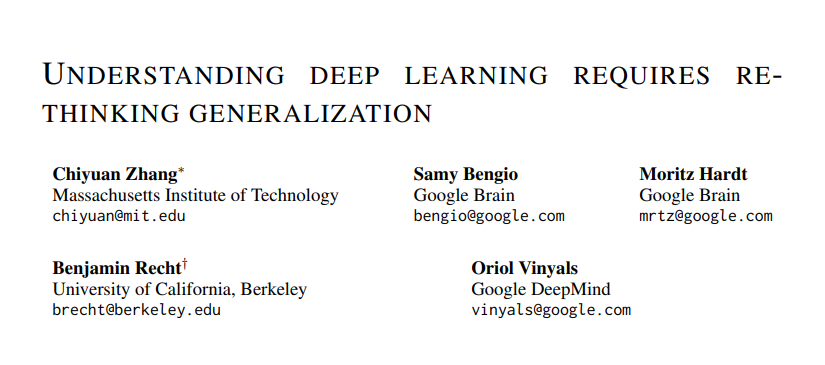

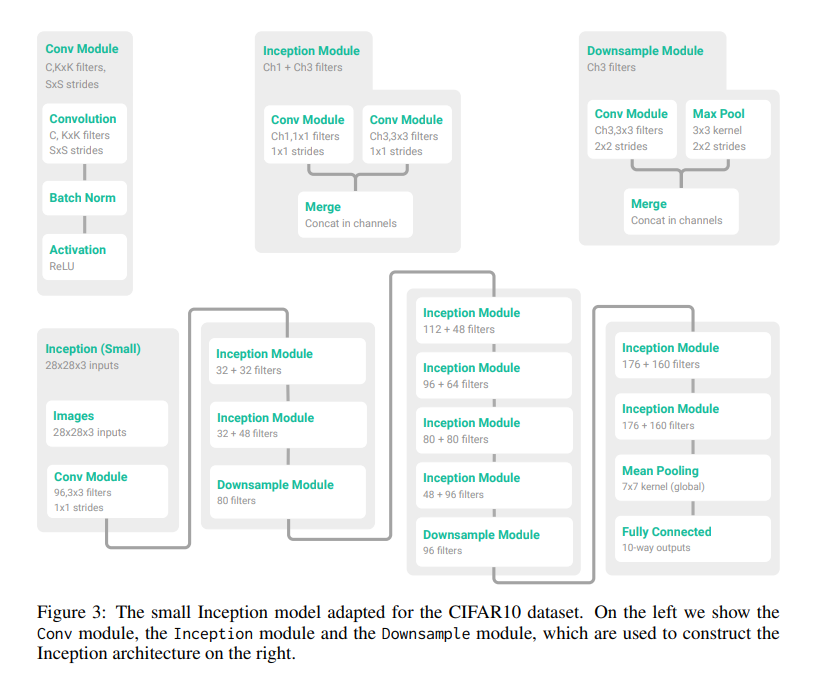

## Imports and initializations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import pickle

In [2]:
input_channels = 3
num_classes = 10

device = 'cuda'
lr = 0.01
epochs = 80
batch_size = 16

## Dataset

In [3]:
# create a list of commands for transforming the image
img_transform = transforms.Compose([
    transforms.ToTensor(), # convert image to tensor
    transforms.CenterCrop(28) # crop from the center
])

# function to normalize each image
def norm_image(data_sample):
    img_tensor = data_sample[0] # image tensors
    label = data_sample[1]

    img_means = img_tensor.mean(axis=[1,2]) # mean of image per channel
    img_sds = img_tensor.std(axis=[1,2]) # overall SD of image per channel

    mean_sub = img_tensor - img_means.unsqueeze(1).unsqueeze(2)
    img_norm = mean_sub.true_divide(img_sds.unsqueeze(1).unsqueeze(2))

    return (img_norm, label)

In [4]:
# training set

all_train = list(datasets.CIFAR10(root = 'data/', transform=img_transform, train = True, download=True))

random.shuffle(all_train)

train_data = all_train[:40000]
train_transformed = list(map(norm_image, train_data))
train_loader = DataLoader(dataset=train_transformed, batch_size=batch_size, shuffle=True)

val_data = all_train[40000:]
val_transformed = list(map(norm_image, val_data))
val_loader = DataLoader(dataset=val_transformed, batch_size=batch_size, shuffle=True)

test_data = datasets.CIFAR10(root='data/', transform=img_transform, train=False, download=True)
test_transformed = list(map(norm_image, val_data))
test_loader = DataLoader(dataset=val_transformed, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


## Implementation of Reduced GoogLeNet

In [5]:
# convolution module
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU() # ReLU
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs) # convolution
        self.batchnorm = nn.BatchNorm2d(out_channels) # batch normalization

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

# inception module
class inception_block(nn.Module):
    def __init__(self, in_channels, out_ch1, out_ch3):
        super(inception_block, self).__init__()
        # first conv module, same padding
        self.ch1 = conv_block(in_channels=in_channels, out_channels=out_ch1, kernel_size=(3,3), stride=(1,1), padding='same')
        # second conv module, same padding
        self.ch3 = conv_block(in_channels=in_channels, out_channels=out_ch3, kernel_size=(3,3), stride=(1,1), padding='same')

    def forward(self,x):
        # concatenate convolution outputs
        return torch.cat([self.ch1(x),self.ch3(x)],1)

# downsample module
class downsample_block(nn.Module):
    def __init__(self, in_channels, conv_out):
        super(downsample_block, self).__init__()
        # conv module
        self.convblock = conv_block(in_channels, conv_out, kernel_size=(3,3), stride=(2,2))
        # max pooling
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2))

    def forward(self,x):
        return torch.cat([self.convblock(x),self.maxpool(x)],1)

# the mini GoogLeNet
class mini_GoogLeNet(nn.Module):
    def __init__(self,in_channels=3, num_classes=10, dropout_prob=0):
        super(mini_GoogLeNet, self).__init__()
        self.conv1 = conv_block(in_channels=3, out_channels=96, kernel_size=(3,3), stride=(1,1))
        self.inception1 = inception_block(96,32,32)
        self.inception2 = inception_block(64,32,48)
        self.downsample1 = downsample_block(80,80)
        self.inception3 = inception_block(160,112,48)
        self.inception4 = inception_block(160,96,64)
        self.inception5 = inception_block(160,80,80)
        self.inception6 = inception_block(160,48,96)
        self.downsample2 = downsample_block(144,96)
        self.inception7 = inception_block(240,176,160)
        self.inception8 = inception_block(336,176,160)
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), padding=(1,1))
        self.dropout = nn.Dropout(p = dropout_prob)
        self.fc = nn.Linear(336,10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.downsample1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.downsample2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

## Model Training

In [6]:
# create the model
model = mini_GoogLeNet(in_channels=3, num_classes=10, dropout_prob=0).to(device=device)

# parameter settings
loss_function = nn.CrossEntropyLoss() # loss funtion
optimizer = optim.SGD(model.parameters(), lr=lr) # optimizer
scheduler = optim.lr_scheduler.LinearLR(optimizer) # scheduler

In [7]:
# initialize results
train_acc = []
train_all_loss = []

test_acc = []
test_all_loss = []

con_mats = []

times = []
train_times = []

In [8]:
# training
def train(epoch):
    model.train()
    curr_loss_train = 0 # loss
    correct_train = 0 # correctly classified training points
    total_train = 0 # total number of training points

    for ind, (data_train, true_labels_train) in enumerate(train_loader):
        data_train = data_train.to(device=device) # use GPU
        true_labels_train = true_labels_train.to(device=device) # use GPU

        out_train = model(data_train) # apply model to training data
        loss_train = loss_function(out_train, true_labels_train) # get loss

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        curr_loss_train += loss_train.item()
        ix, predicted_train = out_train.max(1)
        correct_train += predicted_train.eq(true_labels_train).sum().item()
        total_train += true_labels_train.size(0)

    train_loss = curr_loss_train/len(train_loader) # get loss
    acc_train_val = (correct_train/total_train)*100 # get accuracy

    train_acc.append(acc_train_val)
    train_all_loss.append(train_loss)

# testing
def test(epoch):
    model.eval()
    curr_loss_test = 0 # loss
    correct_test = 0 # correctly classified test points
    total_test = 0 # total number of test points

    num_class = 10
    confusion_matrix = torch.zeros(num_class, num_class)
    with torch.no_grad():
        for data_test, true_labels_test in test_loader:

            data_test = data_test.to(device=device) # use GPU
            true_labels_test = true_labels_test.to(device=device) # use GPU

            out_test = model(data_test) # apply model to training data
            loss_test = loss_function(out_test, true_labels_test) # get loss

            # metrics
            curr_loss_test += loss_test.item()
            ix, predicted_test = out_test.max(1)
            correct_test += predicted_test.eq(true_labels_test).sum().item()
            total_test += true_labels_test.size(0)


    test_loss = curr_loss_test/len(test_loader) # get loss
    acc_test_val = (correct_test/total_test)*100 # get accuracy

    test_acc.append(acc_test_val)
    test_all_loss.append(test_loss)
    con_mats.append(confusion_matrix)

In [9]:
train_start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    print(f"Epoch {epoch}")
    train(epoch)
    test(epoch)
    scheduler.step()

    epoch_time = time.time() - ep_start
    print(f"Epoch time: {epoch_time:0.2f} seconds")
    times.append(epoch_time)

    train_time = time.time() - train_start
    train_times.append(train_time)

print()
print(f"Total training time: {train_time:0.2f} seconds")

Epoch 0
Epoch time: 36.52 seconds
Epoch 1
Epoch time: 36.22 seconds
Epoch 2
Epoch time: 35.11 seconds
Epoch 3
Epoch time: 35.60 seconds
Epoch 4
Epoch time: 35.77 seconds
Epoch 5
Epoch time: 35.14 seconds
Epoch 6
Epoch time: 35.65 seconds
Epoch 7
Epoch time: 35.86 seconds
Epoch 8
Epoch time: 35.02 seconds
Epoch 9
Epoch time: 35.48 seconds
Epoch 10
Epoch time: 35.99 seconds
Epoch 11
Epoch time: 35.22 seconds
Epoch 12
Epoch time: 35.55 seconds
Epoch 13
Epoch time: 35.89 seconds
Epoch 14
Epoch time: 35.22 seconds
Epoch 15
Epoch time: 35.55 seconds
Epoch 16
Epoch time: 35.89 seconds
Epoch 17
Epoch time: 35.06 seconds
Epoch 18
Epoch time: 34.92 seconds
Epoch 19
Epoch time: 35.00 seconds
Epoch 20
Epoch time: 34.86 seconds
Epoch 21
Epoch time: 34.96 seconds
Epoch 22
Epoch time: 34.83 seconds
Epoch 23
Epoch time: 34.84 seconds
Epoch 24
Epoch time: 35.15 seconds
Epoch 25
Epoch time: 35.42 seconds
Epoch 26
Epoch time: 35.20 seconds
Epoch 27
Epoch time: 34.77 seconds
Epoch 28
Epoch time: 34.83 sec

## Export results

In [10]:
# save all results to a dataframe for export
df_res = pd.DataFrame()
df_res['TrainAccuracy'] = train_acc
df_res['TrainLoss'] = train_all_loss
df_res['TestAccuracy'] = test_acc
df_res['TestLoss'] = test_all_loss
df_res['EpochTime'] = times
df_res['Totaltime'] = train_times

df_res.to_csv('results.csv', index=False)

In [11]:
# export all confusion matrices to a pickle
with open('confusion_matrices.pickle','wb') as handle:
    pickle.dump(con_mats, handle)

## Results

In [13]:
pd.set_option('display.max_rows', None)
df_res

,TrainAccuracy,TrainLoss,TestAccuracy,TestLoss,EpochTime,Totaltime
0,45.2450,1.599496,55.99,1.276929,36.518333,36.518558
1,62.3300,1.096489,65.49,0.986192,36.220694,72.739362
2,70.5925,0.869752,73.71,0.761621,35.109761,107.849230
3,75.1725,0.732419,74.09,0.767701,35.598548,143.447880
4,78.7875,0.633222,76.00,0.710064,35.769902,179.217909
5,81.3750,0.554828,76.97,0.689467,35.135815,214.353838
6,84.2950,0.467695,76.93,0.706912,35.653496,250.007441
7,86.9000,0.388380,79.35,0.619393,35.859478,285.867029
8,89.0325,0.327278,78.90,0.650261,35.024331,320.891469
9,90.8000,0.274171,80.33,0.615199,35.478136,356.369710


## Model Accuracy

In [14]:
max_accuracy = df_res['TestAccuracy'].max()
print(f"Highest accuracy reached: {max_accuracy}%")

Highest accuracy reached: 84.71%
